In [34]:
import requests
import time
from datetime import datetime, timedelta
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import lru_cache
import json
import bs4
import re
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
API_KEY = "fh5hj47dynk4nvx4s9ewufj4"
BASE = "https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca"
CAT = "https://api.penguinrandomhouse.com/resources/v2/domains/PRH.US/categories/"
session = requests.Session()

In [3]:
BISAC = pd.read_json("bisac_prefixes.json", typ="series").reset_index()
BISAC.columns = ["prefix", "category"]
BISAC

,prefix,category
0,ANT,Antiques & Collectibles
1,ARC,Architecture
2,BIB,Bibles
3,BIO,Biography & Autobiography
4,BOD,"Body, Mind & Spirit"
5,BUS,Business & Economics
6,CGN,Comics & Graphic Novels
7,COM,Computers
8,CKB,Cooking
9,CRA,Crafts & Hobbies


In [4]:
with open('fiction_BISAC.json', 'r') as f:
    fiction_bisac_codes = json.load(f)
fiction_bisac_codes = fiction_bisac_codes.get('data')
fiction_bisac_codes
f_cat_map = {
    c["catId"]: c["menuText"]
    # c["catId"]: {
    #     "BISAC": c["catUri"],
    #     "Description": c["menuText"]
        for c in fiction_bisac_codes["categories"]
}
f_cat_map

{3000001525: 'Fiction',
 3000001526: 'Absurdist',
 3000001527: 'Action & Adventure',
 3000001528: 'Adaptations & Pastiche',
 3000001529: 'African American & Black',
 3000001530: 'Christian',
 3000001531: 'Erotica',
 3000001532: 'Historical',
 3000001533: 'Mystery & Detective',
 3000001534: 'Urban & Street Lit',
 3000001535: 'Women',
 3000001536: 'Alternative History',
 3000001537: 'Amish & Mennonite',
 3000001538: 'Animals',
 3000001539: 'Anthologies (multiple authors)',
 3000001540: 'Asian American & Pacific Islander',
 3000001541: 'Biographical & Autofiction',
 3000001542: 'Books, Bookstores & Libraries',
 3000001543: 'Buddhist',
 3000001544: 'Christian',
 3000001545: 'Biblical',
 3000001546: 'Classic & Allegory',
 3000001547: 'Collections & Anthologies',
 3000001548: 'Contemporary',
 3000001549: 'Fantasy',
 3000001550: 'Futuristic',
 3000001551: 'Historical',
 3000001552: 'Romance',
 3000001553: 'Historical',
 3000001555: 'Suspense',
 3000001556: 'Western',
 3000001558: 'City Life',

In [5]:
def fetch_istca(catId):

    params = {
            "formatFamily": "Paperback",
            "catId": catId,
            "showFlapCopy": "true",
            "showPublishedBooks": "true",
            "api_key": API_KEY,
        }

    r = session.get(BASE, params=params, timeout=20)

    print("STATUS:", r.status_code)
    print("URL:", r.url)
    print("RAW:", r.text[:250])

    r.raise_for_status()
    return r.json()

In [6]:
data = fetch_istca(catId=3000001550)
print(data)

STATUS: 200
URL: https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca?formatFamily=Paperback&catId=3000001550&showFlapCopy=true&showPublishedBooks=true&api_key=fh5hj47dynk4nvx4s9ewufj4
RAW: {"status":"ok","recordCount":6,"startTimestamp":"2025-11-22T08:01:39Z","endTimestamp":"2025-11-22T08:01:39Z","timeTaken":43,"data":[{"isbn":9780307457196,"isbnHyphenated":"978-0-307-45719-6","workId":19220,"title":"Broken Angel","author":"Sigmund Bro
{'status': 'ok', 'recordCount': 6, 'startTimestamp': '2025-11-22T08:01:39Z', 'endTimestamp': '2025-11-22T08:01:39Z', 'timeTaken': 43, 'data': [{'isbn': 9780307457196, 'isbnHyphenated': '978-0-307-45719-6', 'workId': 19220, 'title': 'Broken Angel', 'author': 'Sigmund Brouwer', 'coverUrl': 'https://images.penguinrandomhouse.com/cover/9780307457196', 'format': {'code': 'TR', 'description': 'Trade Paperback'}, 'subformat': None, 'binding': None, 'editionTarget': {'code': None, 'description': None}, 'trim': '6 x 9', 'editio

In [ ]:
def fetch_istca_multi(catIds, rows=500):
    results = []

    for catId in catIds:

        params = {
            "formatFamily": "Paperback",
            "catId": catId,
            "showFlapCopy": "true",
            "showPublishedBooks": "true",
            "start": 0,
            "rows": rows,
            "api_key": API_KEY,
        }

        r = session.get(BASE, params=params, timeout=20)

        print("\n---")
        print("CATID:", catId)
        print("STATUS:", r.status_code)
        print("URL:", r.url)
        print("RAW:", r.text[:200])

        r.raise_for_status()
        results.append(r.json())

    return results

In [8]:
fetch_istca_multi([3000001525, 3000001526, 3000001527], rows=10)


---
CATID: 3000001525
STATUS: 200
URL: https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca?formatFamily=Paperback&catId=3000001525&showFlapCopy=true&showPublishedBooks=true&start=0&rows=10&api_key=fh5hj47dynk4nvx4s9ewufj4
RAW: {"status":"ok","recordCount":33893,"startTimestamp":"2025-11-22T08:01:39Z","endTimestamp":"2025-11-22T08:01:55Z","timeTaken":15283,"data":[{"isbn":9780140014457,"isbnHyphenated":"978-0-14-001445-7","w

---
CATID: 3000001526
STATUS: 200
URL: https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca?formatFamily=Paperback&catId=3000001526&showFlapCopy=true&showPublishedBooks=true&start=0&rows=10&api_key=fh5hj47dynk4nvx4s9ewufj4
RAW: {"status":"ok","recordCount":93,"startTimestamp":"2025-11-22T08:01:55Z","endTimestamp":"2025-11-22T08:01:55Z","timeTaken":56,"data":[{"isbn":9780140154078,"isbnHyphenated":"978-0-14-015407-8","workId"

---
CATID: 3000001527
STATUS: 200
URL: https://api.penguinrandomhouse

[{'status': 'ok',
  'recordCount': 33893,
  'startTimestamp': '2025-11-22T08:01:39Z',
  'endTimestamp': '2025-11-22T08:01:55Z',
  'timeTaken': 15283,
  'data': [{'isbn': 9780140014457,
    'isbnHyphenated': '978-0-14-001445-7',
    'workId': 323693,
    'title': 'Under the Net',
    'author': 'Iris Murdoch',
    'coverUrl': 'https://images.penguinrandomhouse.com/cover/9780140014457',
    'format': {'code': 'TR', 'description': 'Trade Paperback'},
    'subformat': None,
    'binding': None,
    'editionTarget': {'code': None, 'description': None},
    'trim': '5-1/16 x 7-3/4',
    'edition': '0',
    'onSaleDate': '1977-10-27',
    'exportOnSaleDate': None,
    'price': 16.0,
    'exportPrice': None,
    'globalDivision': None,
    'publishingDivision': 'Penguin Adult HC/TR',
    'imprint': 'Penguin Books',
    'publishingStatus': 'IP',
    'series': None,
    'language': 'E',
    'seq': None,
    'titleBlock': None,
    'description': "<b>Iris Murdoch's debut&mdash;a comic novel about 

In [9]:
fetch = fetch_istca_multi([3000001525, 3000001526, 3000001527], rows=100)


---
CATID: 3000001525
STATUS: 200
URL: https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca?formatFamily=Paperback&catId=3000001525&showFlapCopy=true&showPublishedBooks=true&start=0&rows=100&api_key=fh5hj47dynk4nvx4s9ewufj4
RAW: {"status":"ok","recordCount":33893,"startTimestamp":"2025-11-22T08:01:57Z","endTimestamp":"2025-11-22T08:02:08Z","timeTaken":11171,"data":[{"isbn":9780140014457,"isbnHyphenated":"978-0-14-001445-7","w

---
CATID: 3000001526
STATUS: 200
URL: https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca?formatFamily=Paperback&catId=3000001526&showFlapCopy=true&showPublishedBooks=true&start=0&rows=100&api_key=fh5hj47dynk4nvx4s9ewufj4
RAW: {"status":"ok","recordCount":93,"startTimestamp":"2025-11-22T08:02:09Z","endTimestamp":"2025-11-22T08:02:09Z","timeTaken":178,"data":[{"isbn":9780140154078,"isbnHyphenated":"978-0-14-015407-8","workId

---
CATID: 3000001527
STATUS: 200
URL: https://api.penguinrandomhou

In [13]:
fetch[0]['params']['catId']

'3000001525'

In [18]:
corpus = pd.DataFrame(fetch[0]['data'])
for catid in fetch:
    df = pd.DataFrame(catid['data'])
    
    try:
        corpus = pd.concat([corpus, df], ignore_index=True)
    except NameError:
        corpus = df

corpus = corpus.drop(columns=['isbnHyphenated', 'workId', 'coverUrl',
       'format', 'subformat', 'binding', 'editionTarget', 'trim', 'edition',
       'onSaleDate', 'exportOnSaleDate', 'price', 'exportPrice',
       'globalDivision', 'publishingDivision', 'imprint', 'publishingStatus',
       'series', 'language', 'seq', 'titleBlock', 'authors'])
# corpus.set_index('isbn', inplace=True)
corpus

,isbn,title,author,description
0,9780140014457,Under the Net,Iris Murdoch,<b>Iris Murdoch's debut&mdash;a comic novel ab...
1,9780140014747,The Sandcastle,Iris Murdoch,<b>A sparklingly profound novel about the conf...
2,9780140020038,A Severed Head,Iris Murdoch,<b>A novel about the frightfulness and ruthles...
3,9780140024760,The Unicorn,Iris Murdoch,<b>A brilliant mythical drama about well-meani...
4,9780140030341,The Nice and the Good,Iris Murdoch,From the Booker Prize-winning author of <i>The...
...,...,...,...,...
388,9780307475558,The Adventures of Tom Sawyer,Mark Twain,Mark Twain was one of the nineteenth century's...
389,9780307475565,The Adventures of Huckleberry Finn,Mark Twain,<b>Long cherished by readers of all ages: the ...
390,9780307717108,The Informationist,Taylor Stevens,<b>Governments pay her.</b><br><b>Criminals fe...
391,9780307743176,Jamrach's Menagerie,Carol Birch,<p>Nineteenth-century London comes vividly ali...


In [ ]:
corpus.loc[:, 'description'] = (
    corpus['description']
        .str.replace(r"<.*?>", "", regex=True)            
        .str.replace(r"&[A-Za-z0-9#]+;", "", regex=True)  
        .str.replace(r"\d+", "", regex=True)              
        .str.strip()
)
corpus = corpus.drop_duplicates(subset=['title'], keep='first')
corpus.reset_index(drop=True, inplace=True)
corpus

,isbn,title,author,description
0,9780140014457,Under the Net,Iris Murdoch,Iris Murdoch's debuta comic novel about work a...
1,9780140014747,The Sandcastle,Iris Murdoch,A sparklingly profound novel about the conflic...
2,9780140020038,A Severed Head,Iris Murdoch,A novel about the frightfulness and ruthlessne...
3,9780140024760,The Unicorn,Iris Murdoch,A brilliant mythical drama about well-meaning ...
4,9780140030341,The Nice and the Good,Iris Murdoch,From the Booker Prize-winning author of The Se...
...,...,...,...,...
277,9780307473820,Invasion of Privacy,Christopher Reich,"While meeting with a confidential informant, M..."
278,9780307474506,The Big Book of Adventure Stories,Edited with an Introduction by Otto Penzler,A hair-raising collection of adventure stories...
279,9780307717108,The Informationist,Taylor Stevens,Governments pay her.Criminals fear her.Nobody ...
280,9780307743176,Jamrach's Menagerie,Carol Birch,Nineteenth-century London comes vividly alive ...


In [ ]:
corpus.shape

(282, 4)

#### Step 1. Establish corpus

In [ ]:
# Focus on descriptions only
working_corpus = corpus['description']
working_corpus

0      Iris Murdoch's debuta comic novel about work a...
1      A sparklingly profound novel about the conflic...
2      A novel about the frightfulness and ruthlessne...
3      A brilliant mythical drama about well-meaning ...
4      From the Booker Prize-winning author of The Se...
                             ...                        
277    While meeting with a confidential informant, M...
278    A hair-raising collection of adventure stories...
279    Governments pay her.Criminals fear her.Nobody ...
280    Nineteenth-century London comes vividly alive ...
281    A rollicking romp of a spy thriller from the a...
Name: description, Length: 282, dtype: object

#### Step 2. Perform TF-IDF on corpus

In [ ]:
# TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(working_corpus)

# Get the feature names (words in the vocabulary)
feature_names = vectorizer.get_feature_names_out()

# Convert the sparse matrix to a dense array for easier viewing (for small datasets)
dense_matrix = tfidf_matrix.toarray()

# Create a DataFrame for better readability
tf_idf_df = pd.DataFrame(dense_matrix, columns=feature_names)
tf_idf_df

,abandon,abandoned,abandonment,abbess,abc,abducida,abe,abernathy,abeyance,abiding,...,zoasand,zodiac,zone,zones,zoo,zoos,zoran,zorro,zulu,zuzzo
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
278,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100872,0.0,0.0
279,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
280,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


#### Step 3. Perform NMF

In [ ]:
# Range of topic numbers to test
topic_range = [5, 10, 15, 20, 30, 40, 50]

errors = {}

print("Testing different numbers of topics...\n")

for k in topic_range:
    model = NMF(
        n_components=k,
        init="nndsvd",
        random_state=1,
        max_iter=400
    )

    model.fit(tf_idf_df)
    err = model.reconstruction_err_
    errors[k] = err

    print(f"k = {k:2d}, reconstruction error = {err:.4f}")

# Best k = minimum reconstruction error
best_k = min(errors, key=errors.get)

print("\nOptimal number of topics:", best_k)

Testing different numbers of topics...

k =  5, reconstruction error = 16.1752
k = 10, reconstruction error = 15.9116


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(


k = 15, reconstruction error = 15.6960


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(


k = 20, reconstruction error = 15.4998


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(


k = 30, reconstruction error = 15.1181


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(


k = 40, reconstruction error = 14.7545
k = 50, reconstruction error = 14.3928

Optimal number of topics: 50


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(


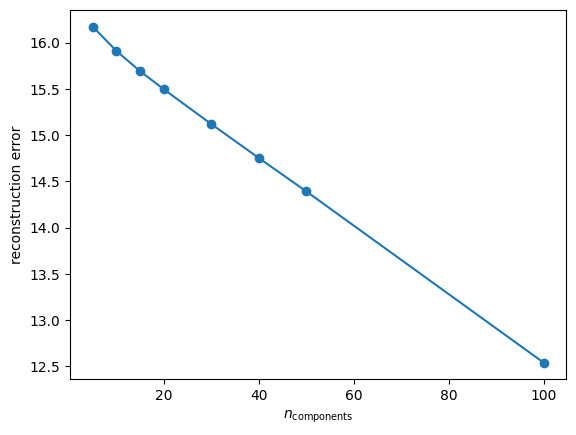

In [ ]:
n_components = [5, 10, 15, 20, 30, 40, 50, 100]
errors = []
for n_component in n_components:
    nmf_ = NMF(n_component, max_iter=10000)
    nmf_.fit(tf_idf_df)
    errors.append(nmf_.reconstruction_err_)
plt.plot(n_components, errors, '-o')
plt.xlabel(r'$n_\text{components}$')
plt.ylabel('reconstruction error');

In [ ]:
# Instantiate the NMF model & specify the number of topics
# Set random_state for reproducibility
n_topics = best_k
nmf_model = NMF(n_components=n_topics, random_state=1).set_output(transform="pandas")

# Fit the NMF model to the TF-IDF matrix
# Note that the 'H' matrix (topic-term distribution) is in nmf_model.components_
# Note that the 'W' matrix (document-topic distribution) can be obtained with model.transform(tfidf_matrix)
nmf_model.fit(tf_idf_df)

# Function to print the top words for each topic (from search results)
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(nmf_model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


#### Find Optimal Number of Topics

In [ ]:
# topic_no =

In [ ]:
# Print the top words per topic from search results
# print_top_words(nmf_model, feature_names, topic_no) # uncomment when using topic_no 
print_top_words(nmf_model, feature_names, 10)

Topic #0:
penguin classic classics notes readers authoritative publisher english scholars bookshelf
Topic #1:
new debut jonny outrageously love seep trina deeba abernathy chance
Topic #2:
la en el una que su por es los novela
Topic #3:
albany cycle ironweed mid legs billy quinns novels irish bones
Topic #4:
sharpe napoleon battle richard enemy french honor wellington napoleonic british
Topic #5:
morgan survivalist home carter camp grid collapse series protect nations
Topic #6:
stories short collection writersa masterpieces irresistible eighty williams surprising fiction
Topic #7:
ravicka gladman renee city architecture ravickians ravickian patova kafka crosses
Topic #8:
glass trilogy detective room locked post ghosts paul novels york
Topic #9:
book moon best times novel york hjorth new post read
Topic #10:
kerouacs road jack meaning freedom gerard changed seekers generation quest
Topic #11:
jonathan rules emma ransom wife christopher international betrayal swiss borders
Topic #12:
coet

In [ ]:
# Get the document-topic distribution
document_topic = nmf_model.transform(tf_idf_df)
document_topic

,nmf0,nmf1,nmf2,nmf3,nmf4,nmf5,nmf6,nmf7,nmf8,nmf9,...,nmf40,nmf41,nmf42,nmf43,nmf44,nmf45,nmf46,nmf47,nmf48,nmf49
0,0.000000,0.000000,0.000142,0.004278,0.000000,0.000000,0.000000,0.005358,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.003998,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.009295,0.007266,0.000000,0.005926,0.000000,0.0,...,0.022266,0.0,0.000000,0.032041,0.000000,0.000816,0.000000,0.000000,0.005821,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.002138,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046060,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.005243,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000378,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
278,0.008890,0.000000,0.000000,0.000401,0.002353,0.003726,0.101663,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.004134,0.000000,0.005467,0.000000,0.000000,0.000000
279,0.000000,0.002087,0.000000,0.000000,0.000146,0.022429,0.000549,0.003928,0.000941,0.0,...,0.000000,0.0,0.000000,0.004721,0.068998,0.000000,0.000000,0.101412,0.000000,0.000000
280,0.000727,0.000000,0.000000,0.004085,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000275,0.023386,0.000000,0.000000,0.002514,0.000000,0.010690,0.033613


#### Step 4. Create a query function

In [ ]:
# Get top words per topic from search results
n_top_words = 10
topic_dict = {}
for topic_idx, topic in enumerate(nmf_model.components_):
        topic_dict[topic_idx] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
topic_dict

{0: ['penguin',
  'classic',
  'classics',
  'notes',
  'readers',
  'authoritative',
  'publisher',
  'english',
  'scholars',
  'bookshelf'],
 1: ['new',
  'debut',
  'jonny',
  'outrageously',
  'love',
  'seep',
  'trina',
  'deeba',
  'abernathy',
  'chance'],
 2: ['la', 'en', 'el', 'una', 'que', 'su', 'por', 'es', 'los', 'novela'],
 3: ['albany',
  'cycle',
  'ironweed',
  'mid',
  'legs',
  'billy',
  'quinns',
  'novels',
  'irish',
  'bones'],
 4: ['sharpe',
  'napoleon',
  'battle',
  'richard',
  'enemy',
  'french',
  'honor',
  'wellington',
  'napoleonic',
  'british'],
 5: ['morgan',
  'survivalist',
  'home',
  'carter',
  'camp',
  'grid',
  'collapse',
  'series',
  'protect',
  'nations'],
 6: ['stories',
  'short',
  'collection',
  'writersa',
  'masterpieces',
  'irresistible',
  'eighty',
  'williams',
  'surprising',
  'fiction'],
 7: ['ravicka',
  'gladman',
  'renee',
  'city',
  'architecture',
  'ravickians',
  'ravickian',
  'patova',
  'kafka',
  'crosses'

In [ ]:
# Identify topics that contain the words in the query
query = 'New york times'

search_topic_list = []
for word in query.lower().split():
    counter = 0
    for topic in topic_dict.values():
        if word in topic:
            search_topic_list.append(counter)
        counter += 1

search_topic_list

[1, 9, 14, 8, 9, 14, 9, 14]

In [ ]:
# Create a dataframe that contains all relevant topics
working_df = pd.DataFrame(document_topic.iloc[:, search_topic_list])
# working_df.set_index(corpus['isbn'], inplace=True)

# Get the total row score for each isbn
working_df['score'] = working_df.iloc[:, 0:].sum(axis=1)
working_df

result = working_df.sort_values(axis=0, by='score', ascending=False).head(10)
result = result[result['score'] > 0]
result

,nmf1,nmf9,nmf14,nmf8,nmf9,nmf14,nmf9,nmf14,score
161,0.00000,0.164132,0.000000,0.000000,0.164132,0.000000,0.164132,0.000000,0.492397
56,0.00000,0.010650,0.008986,0.366102,0.010650,0.008986,0.010650,0.008986,0.425009
170,0.00000,0.124533,0.000000,0.013282,0.124533,0.000000,0.124533,0.000000,0.386880
75,0.00000,0.000000,0.000000,0.383535,0.000000,0.000000,0.000000,0.000000,0.383535
111,0.00030,0.116075,0.000000,0.000000,0.116075,0.000000,0.116075,0.000000,0.348526
262,0.00000,0.000000,0.105283,0.000000,0.000000,0.105283,0.000000,0.105283,0.315849
32,0.00000,0.079824,0.000000,0.000000,0.079824,0.000000,0.079824,0.000000,0.239472
81,0.00000,0.069461,0.006544,0.004054,0.069461,0.006544,0.069461,0.006544,0.232070
148,0.00019,0.076994,0.000000,0.000408,0.076994,0.000000,0.076994,0.000000,0.231581
76,0.00000,0.072802,0.000000,0.000000,0.072802,0.000000,0.072802,0.000000,0.218407


#### Cosine Similarity Query

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def nmf_query_search(query, tfidf, nmf, W, top_k=10):

    # 1. Transform query using the SAME TF-IDF model
    q_tfidf = tfidf.transform([query])

    # 2. Project query into SAME NMF topic space
    q_vec = nmf.transform(q_tfidf)

    # 3. Cosine similarity
    sims = cosine_similarity(q_vec, W).ravel()

    # 4. Sort
    top_idx = sims.argsort()[::-1][:top_k]

    return top_idx, sims[top_idx]


In [ ]:
idx, scores =  nmf_query_search(query='slave traders', tfidf=vectorizer, nmf=nmf_model, W=document_topic, top_k=10)
# idx, scores
corpus.iloc[idx][['isbn', 'title', 'description']]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(


,isbn,title,description
65,9780140112900,The Viceroy of Ouidah,Bruce Chatwins debut novel: Conrads Heart of D...
165,9781681377704,The Skin of Dreams,"In this delightful, cinema-inspired daydream o..."
104,9780425253373,Lunatics,"Philip Horkman is a happy man, the owner of a ..."
160,9781662602733,Happy,"""Leaping, chattering, dancing atop this conund..."
225,9780142181140,Archetype,"A twisty, thought-provoking futuristic tale th..."
146,9781593767112,People from My Neighborhood,Nominated for the Shirley Jackson AwardFrom t...
159,9781662602702,Jonathan Abernathy You Are Kind,"A New York Times Book Review Editors' Choice""D..."
212,9780141002002,The Royal Family,"A rich, haunting novel of street life in San F..."
132,9781590170632,Moravagine,"At once truly appalling and appallingly funny,..."
261,9780307279958,A Simple Plan,Spectacular. . . . Ten shades blacker and sev...


#### Corpus v2 
27 Categories, 27 titles each

In [ ]:
# Get the category + 257 random categories
# Add the category id

In [29]:
# List of categories
f_cat_id = {}
for key, value in f_cat_map.items():
    if value not in f_cat_id.values():
        f_cat_id[key] = value

f_cat_id

{3000001525: 'Fiction',
 3000001526: 'Absurdist',
 3000001527: 'Action & Adventure',
 3000001528: 'Adaptations & Pastiche',
 3000001529: 'African American & Black',
 3000001530: 'Christian',
 3000001531: 'Erotica',
 3000001532: 'Historical',
 3000001533: 'Mystery & Detective',
 3000001534: 'Urban & Street Lit',
 3000001535: 'Women',
 3000001536: 'Alternative History',
 3000001537: 'Amish & Mennonite',
 3000001538: 'Animals',
 3000001539: 'Anthologies (multiple authors)',
 3000001540: 'Asian American & Pacific Islander',
 3000001541: 'Biographical & Autofiction',
 3000001542: 'Books, Bookstores & Libraries',
 3000001543: 'Buddhist',
 3000001545: 'Biblical',
 3000001546: 'Classic & Allegory',
 3000001547: 'Collections & Anthologies',
 3000001548: 'Contemporary',
 3000001549: 'Fantasy',
 3000001550: 'Futuristic',
 3000001552: 'Romance',
 3000001555: 'Suspense',
 3000001556: 'Western',
 3000001558: 'City Life',
 3000001559: 'Classics',
 3000001560: 'Coming Of Age',
 3000001561: 'Crime',
 3

In [32]:
list(f_cat_id.keys())

[3000001525,
 3000001526,
 3000001527,
 3000001528,
 3000001529,
 3000001530,
 3000001531,
 3000001532,
 3000001533,
 3000001534,
 3000001535,
 3000001536,
 3000001537,
 3000001538,
 3000001539,
 3000001540,
 3000001541,
 3000001542,
 3000001543,
 3000001545,
 3000001546,
 3000001547,
 3000001548,
 3000001549,
 3000001550,
 3000001552,
 3000001555,
 3000001556,
 3000001558,
 3000001559,
 3000001560,
 3000001561,
 3000001562,
 3000001563,
 3000001564,
 3000001565,
 3000001566,
 3000001567,
 3000001568,
 3000001570,
 3000001573,
 3000001574,
 3000001575,
 3000001576,
 3000001578,
 3000001579,
 3000001580,
 3000001581,
 3000001582,
 3000001583,
 3000001584,
 3000001585,
 3000001586,
 3000001589,
 3000001592,
 3000001593,
 3000001594,
 3000001595,
 3000001596,
 3000001598,
 3000001599,
 3000001600,
 3000001601,
 3000001603,
 3000001604,
 3000001605,
 3000001606,
 3000001607,
 3000001608,
 3000001614,
 3000001615,
 3000001617,
 3000001621,
 3000001622,
 3000001623,
 3000001624,
 3000001625,

In [37]:
def build_corpus(rows=20):
    API_KEY = "fh5hj47dynk4nvx4s9ewufj4"
    BASE = "https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca"
    CAT = "https://api.penguinrandomhouse.com/resources/v2/domains/PRH.US/categories/"
    session = requests.Session()

    # Create list of categories
    with open('fiction_BISAC.json', 'r') as f:
        fiction_bisac_codes = json.load(f)
    fiction_bisac_codes = fiction_bisac_codes.get('data')
    f_cat_map = {
        c["catId"]: c["menuText"]
            for c in fiction_bisac_codes["categories"]
    }
    f_cat_id = {}
    for key, value in f_cat_map.items():
        if value not in f_cat_id.values():
            f_cat_id[key] = value
    
    # Create list of 
    results = []
    for catId in list(f_cat_id.keys()):

        params = {
            "formatFamily": "Paperback",
            "catId": catId,
            "showFlapCopy": "true",
            "showPublishedBooks": "true",
            "start": 0,
            "rows": rows,
            "api_key": API_KEY,
        }

        r = session.get(BASE, params=params, timeout=20)

        #print("\n---")
        #print("CATID:", catId)
        #print("STATUS:", r.status_code)
        #print("URL:", r.url)
        #print("RAW:", r.text[:200])

        r.raise_for_status()
        results.append(r.json())
    
    # Build the dataframe
    corpus = pd.DataFrame(results[0]['data'])
    for catid in results:
        df = pd.DataFrame(catid['data'])
        
        try:
            corpus = pd.concat([corpus, df], ignore_index=True)
        except NameError:
            corpus = df

    corpus = corpus.drop(columns=['isbnHyphenated', 'workId', 'coverUrl',
        'format', 'subformat', 'binding', 'editionTarget', 'trim', 'edition',
        'onSaleDate', 'exportOnSaleDate', 'price', 'exportPrice',
        'globalDivision', 'publishingDivision', 'imprint', 'publishingStatus',
        'series', 'language', 'seq', 'titleBlock', 'authors'])

    return corpus

In [27]:
corpus = pd.DataFrame(fetch[0]['data'])
for catid in fetch:
    df = pd.DataFrame(catid['data'])
    
    try:
        corpus = pd.concat([corpus, df], ignore_index=True)
    except NameError:
        corpus = df

corpus = corpus.drop(columns=['isbnHyphenated', 'workId', 'coverUrl',
       'format', 'subformat', 'binding', 'editionTarget', 'trim', 'edition',
       'onSaleDate', 'exportOnSaleDate', 'price', 'exportPrice',
       'globalDivision', 'publishingDivision', 'imprint', 'publishingStatus',
       'series', 'language', 'seq', 'titleBlock', 'authors'])
# corpus.set_index('isbn', inplace=True)
corpus

,isbn,title,author,description
0,9780140014457,Under the Net,Iris Murdoch,<b>Iris Murdoch's debut&mdash;a comic novel ab...
1,9780140014747,The Sandcastle,Iris Murdoch,<b>A sparklingly profound novel about the conf...
2,9780140020038,A Severed Head,Iris Murdoch,<b>A novel about the frightfulness and ruthles...
3,9780140024760,The Unicorn,Iris Murdoch,<b>A brilliant mythical drama about well-meani...
4,9780140030341,The Nice and the Good,Iris Murdoch,From the Booker Prize-winning author of <i>The...
...,...,...,...,...
75,9780140294378,Sharpe's Siege (#9),Bernard Cornwell,Sharpe's mission has seemed simple: capture a ...
76,9780140294385,Sharpe's Revenge (#10),Bernard Cornwell,"<b>When his honor and reputation are at stake,..."
77,9780140294392,Waterloo (#11),Bernard Cornwell,"<b>June 1815: The Duke of Wellington, the Prin..."
78,9780140390148,Uncle Remus,Joel Chandler Harris,"The dialect, lore, and flavor of black life in..."


In [38]:
build_corpus()

HTTPError: 404 Client Error: Not Found for url: https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca?formatFamily=Paperback&catId=3000001563&showFlapCopy=true&showPublishedBooks=true&start=0&rows=20&api_key=fh5hj47dynk4nvx4s9ewufj4